In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda, UpSampling2D



In [2]:
# Load CIFAR-10 data
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [3]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [4]:
latent_dim = 64  # Size of the latent space

# Encoder
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# Mean and log variance for the latent space
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Sampling layer
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


In [6]:
# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(8 * 8 * 128, activation='relu')(decoder_input)
x = Reshape((8, 8, 128))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

# Define encoder and decoder models
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, decoded, name='decoder')


In [11]:
# Define the VAE model
output_img = decoder(encoder(input_img)[2])
vae = Model(input_img, output_img, name='vae')


In [13]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import binary_crossentropy

class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        input_img, output_img, z_mean, z_log_var = inputs

        # Reconstruction loss
        reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(input_img), 
                                                  tf.keras.backend.flatten(output_img))
        reconstruction_loss *= 32 * 32 * 3

        # KL divergence loss
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        # Total VAE loss
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return output_img


In [15]:
# Define the VAE model by combining encoder and decoder with the loss layer
output_img = decoder(encoder(input_img)[2])  # Get decoded image from sampled latent vector

# Add the custom loss layer
vae_output = VAELossLayer()([input_img, output_img, z_mean, z_log_var])

# Define the final VAE model
vae = Model(input_img, vae_output, name='vae')
vae.compile(optimizer='adam')


In [16]:
# Train the VAE
vae.fit(x_train, x_train,
        epochs=5,
        batch_size=128,
        validation_data=(x_test, x_test))


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 305s 741ms/step - loss: 1996.9752 - val_loss: 1877.4734
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 293s 749ms/step - loss: 1864.7852 - val_loss: 1854.3214
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 283s 723ms/step - loss: 1848.4150 - val_loss: 1845.2275
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 293s 749ms/step - loss: 1841.4777 - val_loss: 1841.8668
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 294s 752ms/step - loss: 1839.5265 - val_loss: 1839.6545


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step


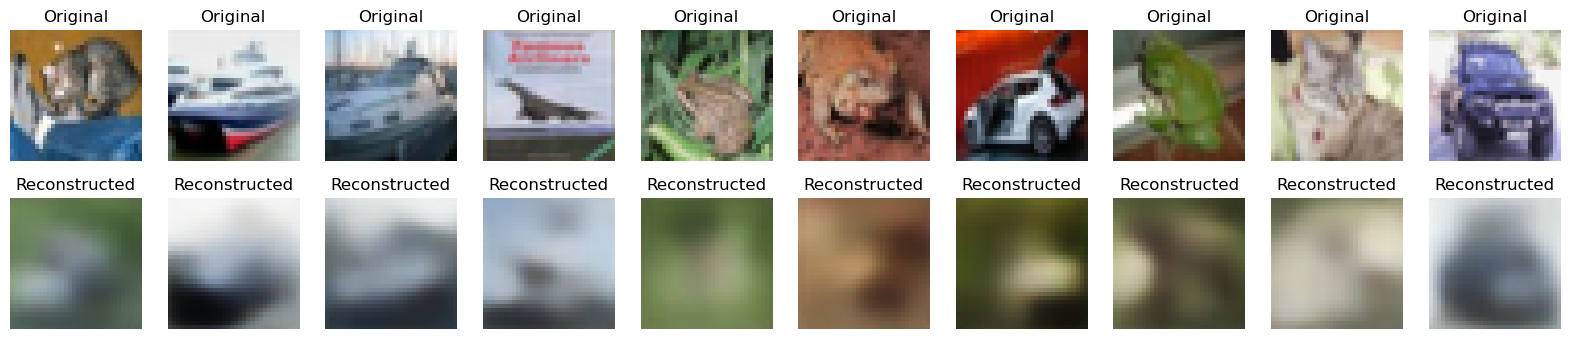

In [19]:
# Encode and decode some test images
encoded_imgs = encoder.predict(x_test)[2]
decoded_imgs = decoder.predict(encoded_imgs)

# Display original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")
    
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()
